# Challenge: Factors that affect life expectancy


In this challenge I work with this [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). It contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

I will access the data from the Thinkful bootcamp's database using a given set of credentials to complete the following tasks:

* Find the factors that affect the life expectancy. Specifically, find out which factors increase the expected life in the countries and which factors decrease it.

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss techniques that would be the most suitable in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

* Explore the data exploration techniques, paying special attention to your target variable. Focus on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, select a suite of variables that would be ideal in the modeling phase. More concretely, discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings using effective visualization.

I'll begin by loading relevant libraries/tools, loading the data set, and taking a quick peek at the data.

### 1. Loading Up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import seaborn as sns
%matplotlib inline
from scipy.stats import boxcox
from sklearn.preprocessing import normalize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Start by connecting to the Thinkful database and reading in the data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user,
                                                            postgres_pw, postgres_host, postgres_port, postgres_db))

main_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# No need for an open connection as we're only doing a single query, so close it
engine.dispose()

# Now let's take a quick peek at the data
main_df.head(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### 2. Detecting Problems

To easily find some issues with the data, let's take a look at how many null values we have using the info function.

In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

Looks like we have missing values in Life expectancy, Adult Mortality, Alcohol, Hepatitis B, BMI, Polio, Total expenditure, Diphtheria, GDP, Population, thinness 1-19 years, thinness 5-9 years, Income composition of resources, and Schooling. I chose a few specific empty variables to be filled in via interpolation because they are values that one would expect to increase over time, so giving them an average value for their country wouldn't make much sense. For example, if we have 10 years of data for one country's GDP and the 3rd year is missing, interpolating between the 2nd and 4th year would create a more realistic value than taking an average over all 10 years and applying that. Other than these types of cases, I deemed that the average for each country should serve our purposes. Below is a comprehensive list of my choices for each method for reference.

- Fill in with mean:
Life expectancy, Adult Mortality, Alcohol, Hepatitis B, BMI, Polio, Diphtheria, Income composition of resources, Schooling

- Fill in with interpolation:
Total expenditure, GDP, Population,  thinness 1-19 years, thinness 5-9 years

Now let's go ahead and fill our gaps.

In [4]:
# Create lists to loop over to fill in values appropriately
mean_list = ['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio', 'Diphtheria ',
             'Income composition of resources', 'Schooling']
interp_list = ['Total expenditure', 'GDP', 'Population',  ' thinness  1-19 years', ' thinness 5-9 years'] 

# Create a copy of the dataframe so we don't lose the raw data
life_df = main_df.copy()

# Create a list of countries so we can appropriately target new values
cntry_list = life_df['Country'].unique()

# Now loop over the mean list and replace values that are calculated by country
for col in mean_list:
    for cntry in cntry_list:
        life_df.loc[life_df['Country'] == cntry, col].fillna(life_df[life_df['Country'] == cntry][col].mean(), inplace=True)

# Then loop over the variables we want to be interpolated and fill those in as well
for col in interp_list:
    life_df.loc[:, col].interpolate(inplace=True)

Let's use the info function again and see how our data looks now.

In [5]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2938 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

This is already looking better. However, seeing as we are still getting some non-null values that weren't filled by the above methods, this tells me that some countries may have insufficient amounts of data. That is, if there is only one or two years of data for a smaller country, we might not be able to produce a realistic value to place into these holes. Thus, analysis on these countries would not be accurate at this time and could throw off our data analysis if we left them in. I have therefore decided to drop these rows from our dataframe copy as we still keep a large percentage of our information.

In [6]:
life_df = life_df.dropna()

This should clear up most of our identified incidents of empty or "nonsense" values, and give us a cleaner data set to move forward with. You may have also noticed that the column names have some odd spaces at the beginning and ends of the text, but these won't affect our calculations.

Next let's use some box plots to find any outliers we may want to deal with. Outliers can distort our results and lead us to make incorrect conclusions. These data points can come from human error, such as mistypes in data entry, or procedural error, such as obtaining data from the wrong sources by accident. To deal with these pests we'll go through each column, find which have outliers, and then cut out (or "winsorize") a percentage to make well sure we're not including mistakes.

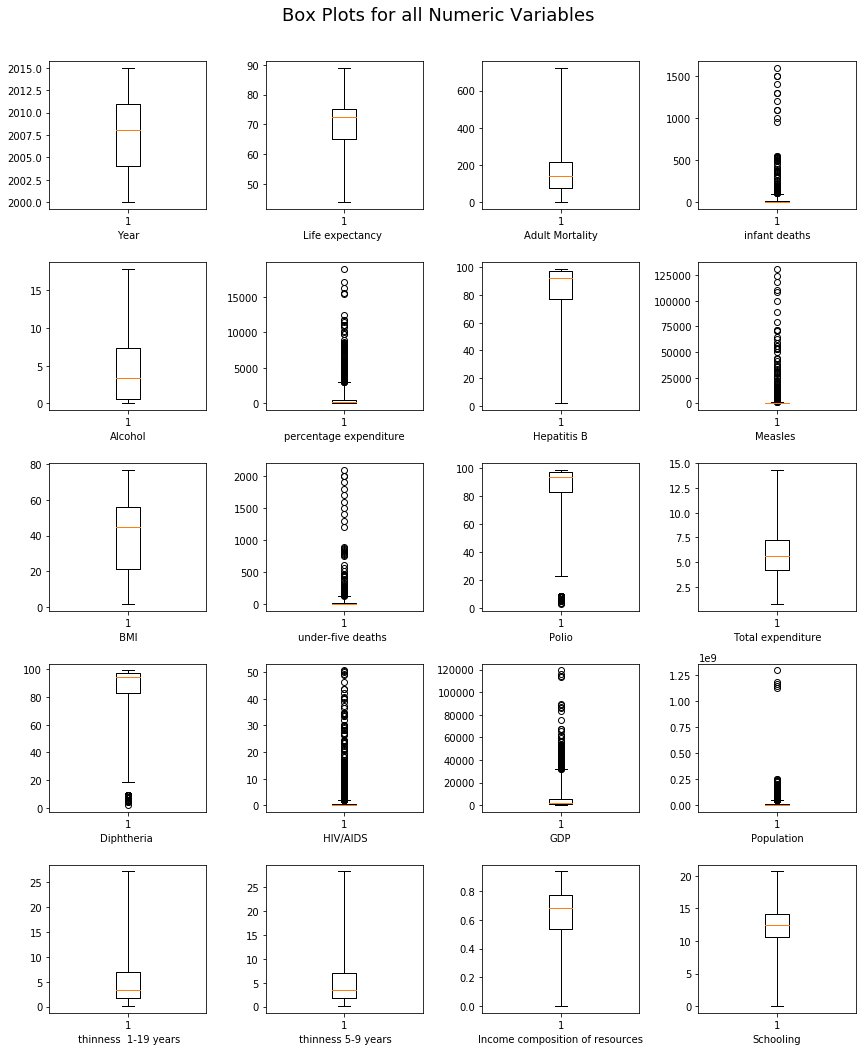

In [7]:
# Create a list of all the columns, and drop the non-numerical ones for now
all_cols = life_df.columns
all_cols = all_cols.drop('Country')
all_cols = all_cols.drop('Status')

# Now we can create box/whisker plots
plt.figure(figsize=(12,14))
loopnum = 1

for col in all_cols:
    plt.subplot(5, 4, loopnum)
    plt.boxplot(life_df[col], whis=5)
    plt.xlabel(col)
    loopnum += 1

plt.suptitle('Box Plots for all Numeric Variables', y=1.04, fontsize=18) 
plt.tight_layout()
plt.show()

Looks like we can winsorize infant deaths, percentage expenditure, measles, under-five deaths, HIV/AIDS, GDP, Population, polio, and diphtheria. I'll simply take a percentage of outliers out for now in their relative directions.

In [8]:
# Create lists of variables we want to winsorize in the same direction, and then winsorize them

win1_list = ['infant deaths', 'percentage expenditure', 'Measles ', 'under-five deaths ', ' HIV/AIDS', 'GDP', 'Population']

for col1 in win1_list:
    life_df[col1] = winsorize(life_df[col1], (0, 0.10))
    
win2_list = ['Polio', 'Diphtheria ']

for col2 in win2_list:
    life_df[col2] = winsorize(life_df[col2], (0.01, 0))

Now that we are confident we have dealt with the above issues, we can move along and start getting to the meat of our investigation.

### 3. Exploring the Data

The easiest way to visually see which variables are (or aren't) important is by calculating their correlations to our target variable. In this case, our target variable is life expectancy.

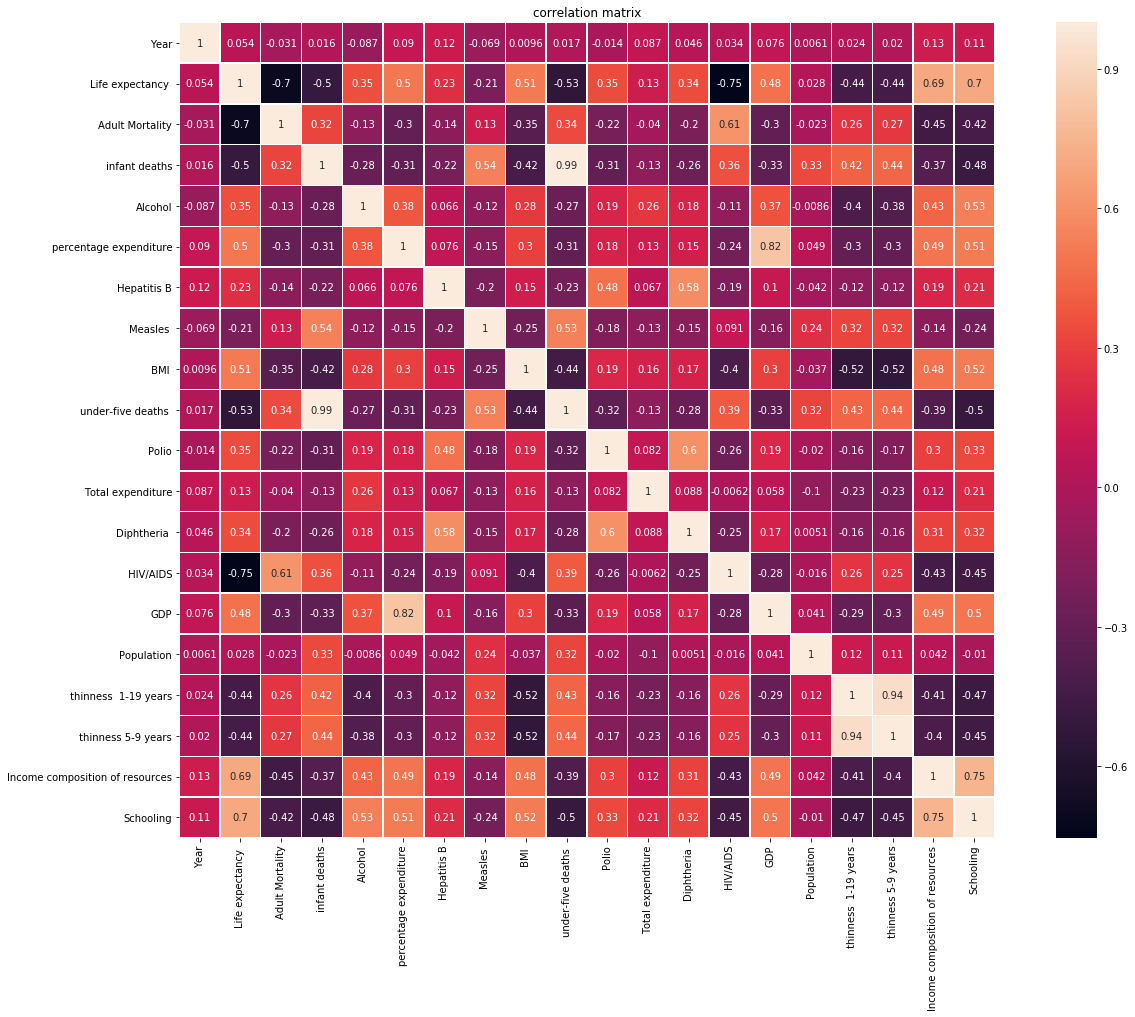

In [9]:
# Calculate the correlations
corr_df = life_df.corr()

# Plot them in a heatmap for visual ease of comparison
plt.figure(figsize=(22,15))
sns.heatmap(corr_df, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")
plt.show()

To narrow down which variables we want to focus in on, we read along the "Life Expectancy" row (or column) and look for the largest values. If the values are negative, it tells us that they decrease life expectancy, and the opposite is true if they are positive. Looking at this correlation matrix however, two things may stand out to you as they did to me. Why are Alcohol and Hepatitis B showing positive correlations with life expectancy? Shouldn't those be negative?

Well, in the case of Hepatitis B, this happens because the measure being shown in this data is "immunization coverage among 1-year-olds (%)", so actually it makes sense that it would be positive. The more immunizations given to 1 year olds, the less Hepatitis B will be contracted, and the longer they will live. For alcohol however, we'll take another look at our data.

In [10]:
# Show descriptive statistics for the Alcohol variable
life_df['Alcohol'].describe()

count    2088.000000
mean        4.336102
std         3.983393
min         0.010000
25%         0.610000
50%         3.370000
75%         7.312500
max        17.870000
Name: Alcohol, dtype: float64

In this data, the Alcohol column is giving us the "Alcohol recorded per capita (15+) consumption in litres of pure alcohol". The above descriptive statistics tell us that a large majority of countries (75%) averaged ~7.3 liters of pure alcohol per capita in a year. To put this into perspective, if you take a standard 750 ml bottle of wine, which has 12.5% alcohol on average, this calculates out to .9375 liters of pure alcohol in a bottle. This equates to saying that in 75% of countries, people have a bit over 7 bottles of wine in a year. Considering there are a number of scientific studies showing the benefits of the occasional glass of wine (which is beyond the scope of this analysis, but feel free to Google it) I can then determine that this correlation is not all that surprising after all.

Moving on, I decided to only consider variables that had a correlation value of 40% or above. I have listed these below:

Our variables that have a negative impact on life expectancy, in descending order, are:
1. HIV/AIDS (-0.75)
2. Adult Mortality (-0.7)
3. under-five deaths (-0.53)
4. infant deaths (-0.5)
5. thinness 5-9 years (-0.44)
6. thinness 1-19 years (-0.44)

While on the positive side, variables that are helpful to life expectancy, in descending order, are:
1. Schooling (0.7)
2. Income composition of resources (0.69)
3. BMI (0.51)
4. percentage expenditure (0.5)
5. GDP (0.48)

### 4. Variables that would be ideal in the modeling phase.

To pick our strongest features, I decided to thin the herd slightly. I dropped "thinness 1-19 years" as it seems to be telling almost the same story as "thinness 5-9 years". This is shown by the correlation value between them of 0.94. I also dropped "infant deaths" because it is highly correlated to "under-five deaths". Under-five deaths was chosen over infant deaths because it had more correlation to life expectancy.

Thus, I end up with this final list:
##### Negative Variables:
1. HIV/AIDS
2. Adult Mortality
3. under-five deaths
4. thinness 5-9 years

##### Positive Variables:
1. Schooling
2. Income composition of resources
3. BMI
4. percentage expenditure
5. GDP

### 5. Summary of Findings

In conclusion, if we as a species want to improve life expectancy world-wide, I would recommend focusing on the following 9 aspects of measurable health, in descending order of impact.

1. HIV/AIDS
2. Schooling
3. Adult Mortality
4. Income composition of resources
5. under-five deaths
6. BMI
7. percentage expenditure
8. GDP
9. thinness 5-9 years

The below graph shows the 4 most detrimental variables to human life expectancy, and their calculated weight on it. The most critical issue to tackle would be HIV/AIDS, and then so on down the line.

Text(0.5, 1.0, '4 Most Negative Correlations:')

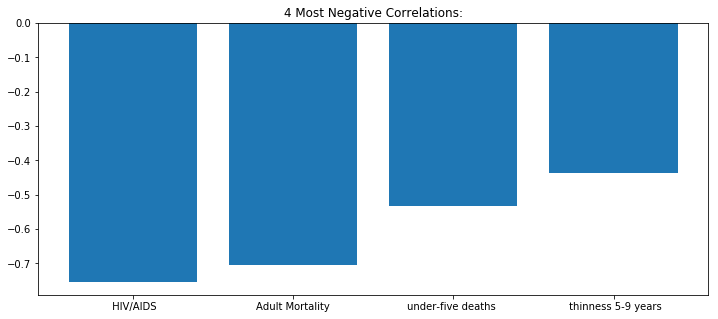

In [11]:
# Create a set of data for only the negative variables we want to show and graph them
corr_df = corr_df.sort_values(by=['Life expectancy '])
neg = corr_df['Life expectancy '].head(6)
neg = neg.drop(' thinness  1-19 years')
neg = neg.drop('infant deaths')

plt.figure(figsize=(12,5))
plt.bar(neg.keys(), height=neg)
plt.title('4 Most Negative Correlations:')

This next graph shows the 6 most influential variables that can increase life expectancy, and their mathematical relation to it. Our data tells us that the key that would have the most impact is schooling, and then so on from right to left.

Text(0.5, 1.0, '5 Most Positive Correlations:')

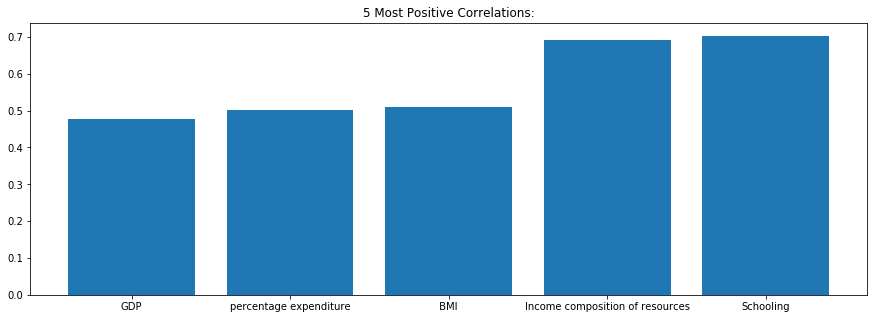

In [12]:
# Create a set of data for only the positive variables we want to show and graph them
pos = corr_df['Life expectancy '].tail(6)
pos = pos.drop('Life expectancy ')

plt.figure(figsize=(15,5))
plt.bar(pos.keys(), height=pos)
plt.title('5 Most Positive Correlations:')